##  Advanced Finding lane

The goals / steps of this project are the following:
* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## Import Packages

In [2]:
#import some useful packeages
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.patches import Polygon
%matplotlib inline

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

## Camera Calibration

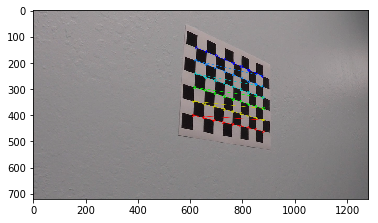

In [3]:
def Camera_Calibration(images, nx, ny):
   
    # Prepare object points
    objp = np.zeros((nx * ny, 3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # In real world, it is three dimentionals
    imgpoints = [] # In image, it is two dimentionals

    # Go through the calibration images
    for fname in images:    
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        # Looking for corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            # show the corners found on the distorted picture.
            cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
            plt.imshow(img)
            
    # Camera calibration, given object points, image points, and the shape of the grayscale image
    if (len(objpoints) > 0):
        # Camera successfully calibrated.
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

    return ret, mtx, dist, rvecs, tvecs
        
# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

ret, mtx, dist, rvecs, tvecs = Camera_Calibration(images,9,6)

## Distortion Correction

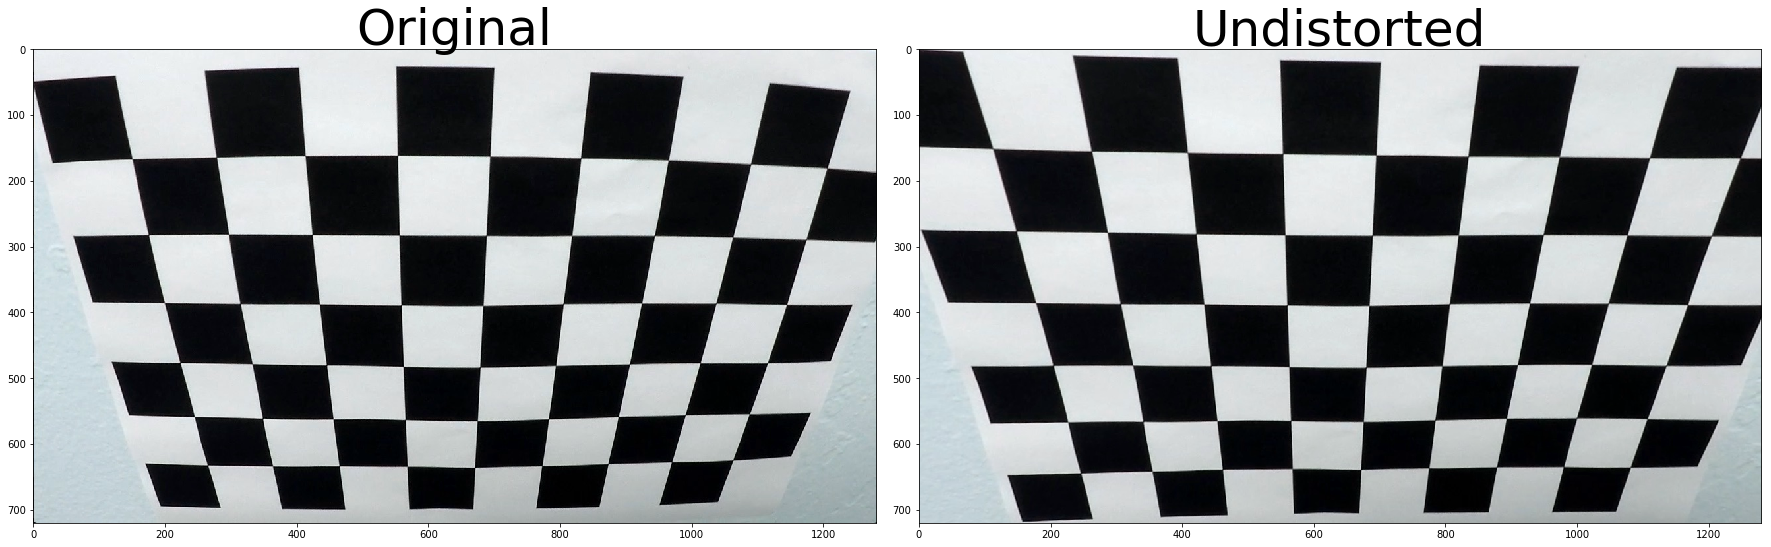

In [4]:
#after camera calibration, undistort the distorted pictures.
def Distortion_Correction(img,mtx,dist):
    undist = cv2.undistort(img,mtx,dist,None,mtx)
    return undist

#try out with one of the test pictures and show the original and undistorted picture side by side. 
img = cv2.imread('./camera_cal/calibration2.jpg')
undistorted = Distortion_Correction(img,mtx,dist)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Apply Sobel Operator

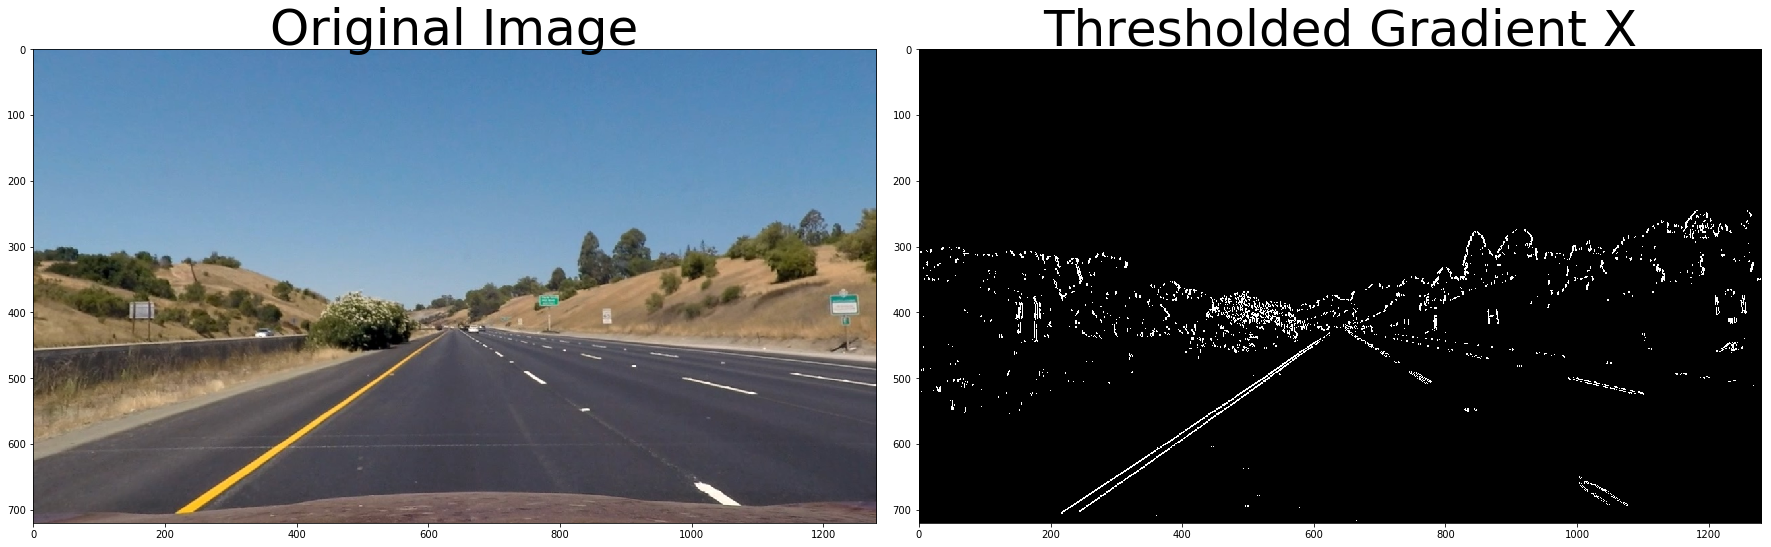

In [5]:
# Define sobel operators to find all the gradients that lie in the threshold
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply x or y gradient with the OpenCV Sobel() function
 
    #gradients in x direction emphasized edeges closer to vertical
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, 15))
    #gradients in y direction emphasized edeges closer to horizontal
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, 15)) 
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))  
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel) 
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    
    return binary_output

# Visualize the result
img = cv2.imread('./test_images/straight_lines1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.undistort(img, mtx, dist, None, mtx)
grad_binary_x = abs_sobel_thresh(img, orient='x',thresh_min=35,thresh_max=100)
# Plot 
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(grad_binary_x, cmap='gray')
ax2.set_title('Thresholded Gradient X', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

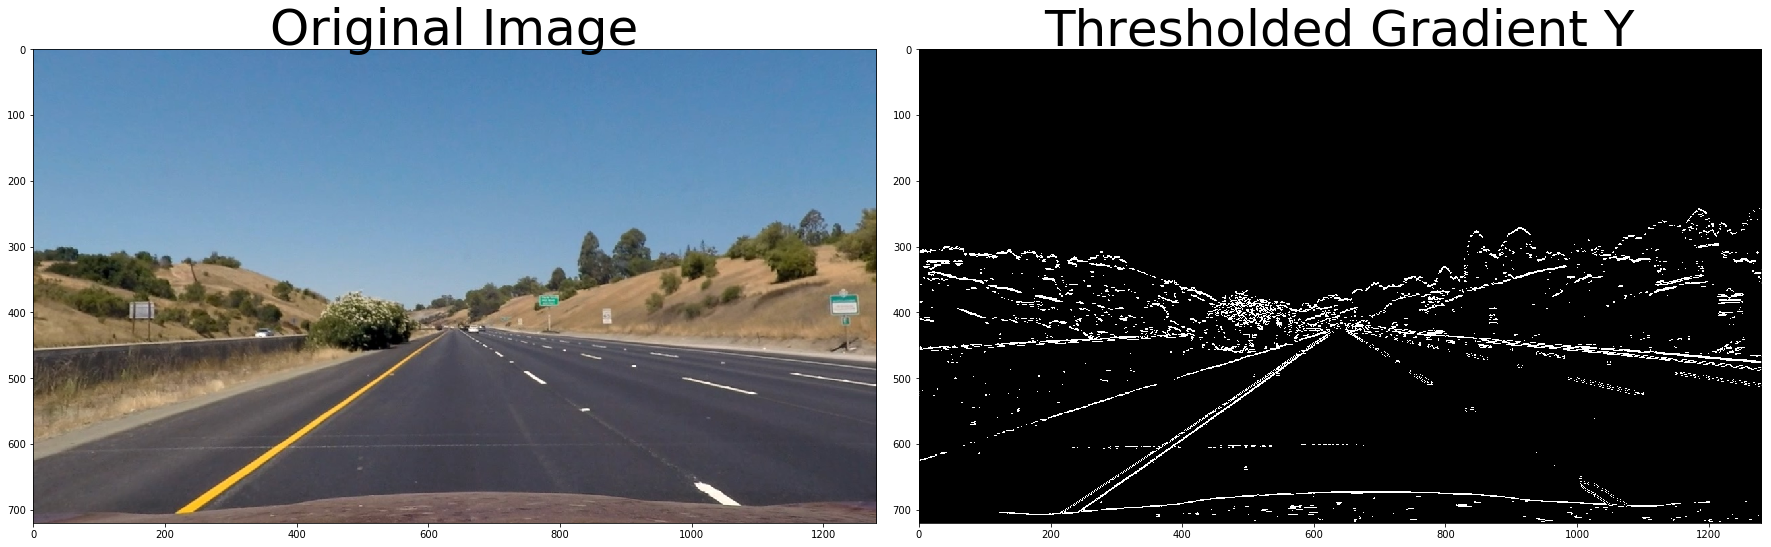

In [6]:
#gradient in Y direction
grad_binary_y = abs_sobel_thresh(img, orient='y',thresh_min=35,thresh_max=100)
# Plot 
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(grad_binary_y, cmap='gray')
ax2.set_title('Thresholded Gradient Y', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Find Gradient Magnittude Threshold

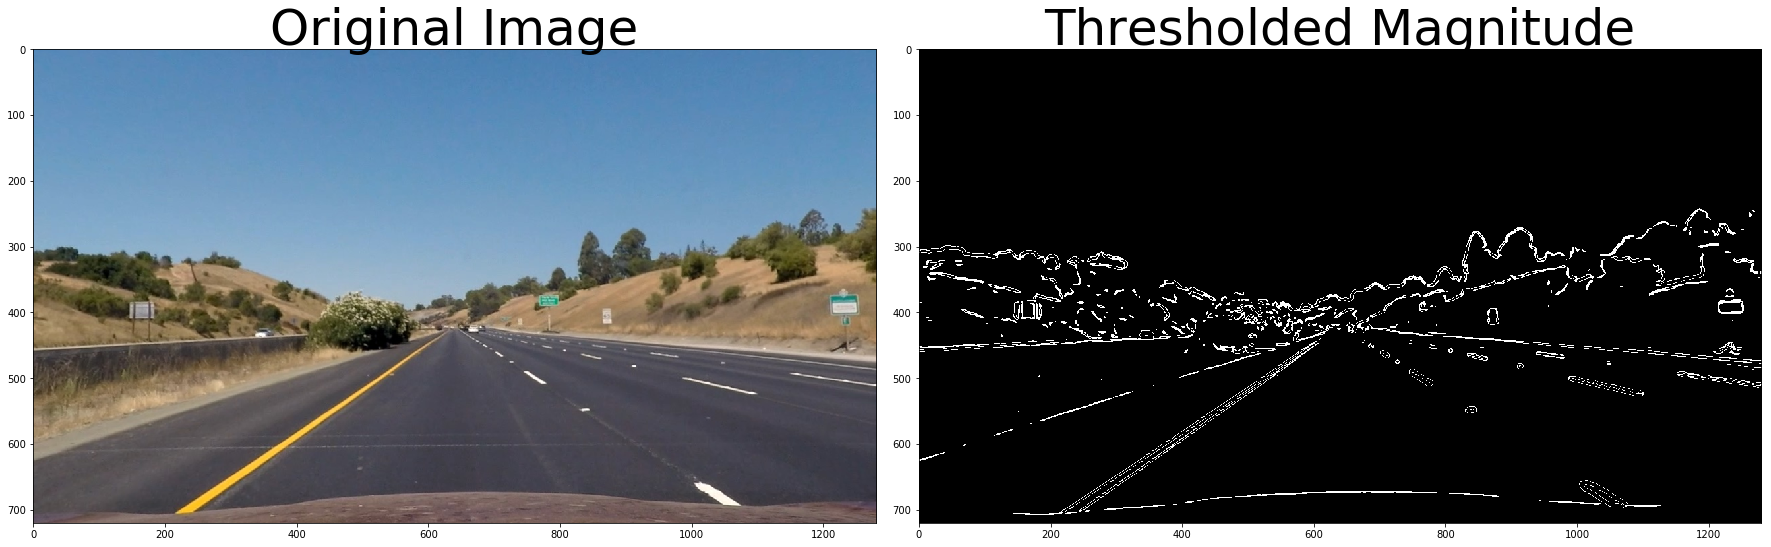

In [7]:
def mag_threshold(img, kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=kernel)
    # gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale gradient magnitude
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # if it is within threshold, output 1 otherwise output 0
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    return binary_output

# Visualize the result
mag_binary = mag_threshold(img, kernel=15, mag_thresh=(65, 100))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(mag_binary, cmap='gray')
ax2.set_title('Thresholded Magnitude', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Find Gradient Direction

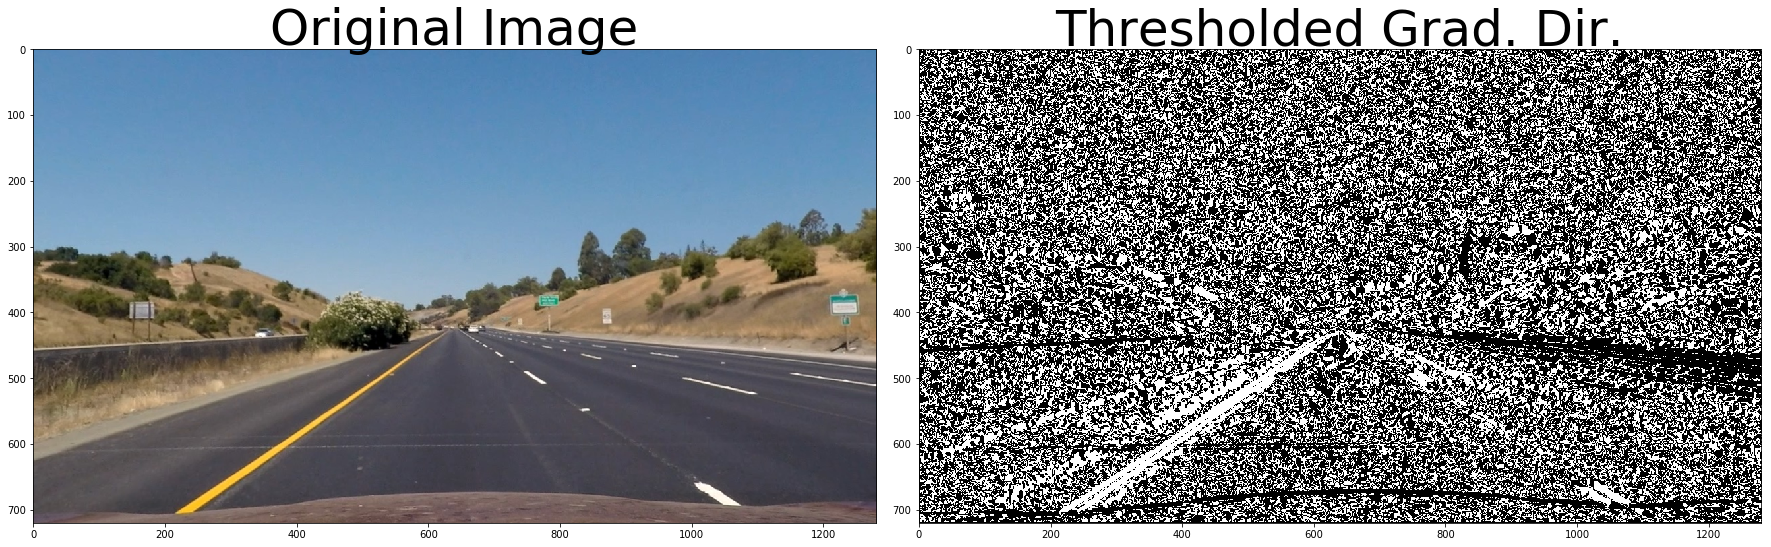

In [8]:
def dir_threshold(img, kernel=3, thresh=(0, np.pi/2)):
    #Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=kernel)
    #absolute value of the gradient direction, 
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    # if it is within threshold, output 1 otherwise output 0
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    return binary_output

#visualize the result
dir_binary = dir_threshold(img, kernel=15, thresh=(0.7, 1.3))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dir_binary, cmap='gray')
ax2.set_title('Thresholded Grad. Dir.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Color Thresholding (HLS)

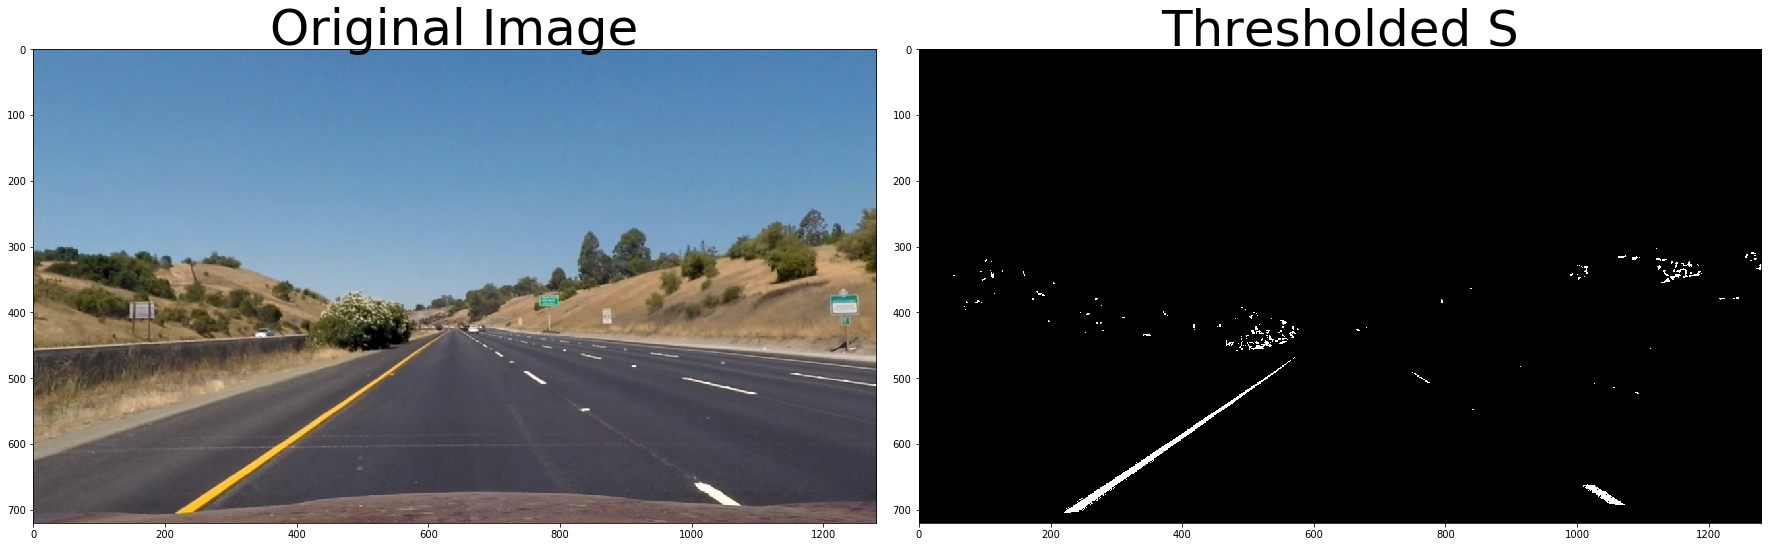

In [9]:
def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    #Accoding to lecture, S values usually give the best performance
    s_channel = hls[:,:,2] 
    binary_output = np.zeros_like(s_channel)
    # if it is within threshold, output 1 otherwise output 0
    binary_output[(s_channel >= thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

#visualize the result
hls_binary = hls_select(img, thresh=(175, 255))

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(hls_binary, cmap='gray')
ax2.set_title('Thresholded S', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

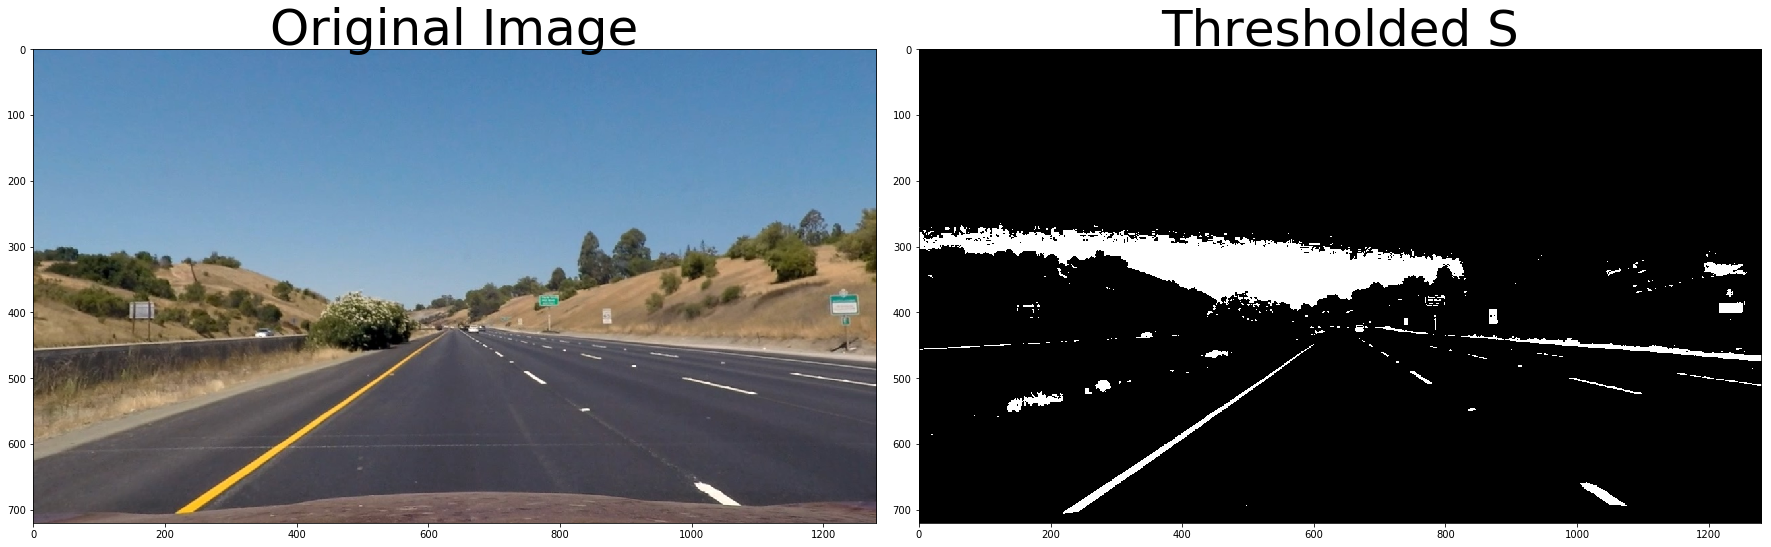

In [12]:
def luv_select(img, thresh=(225, 255)):
    luv = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    
    #Accoding to lecture, S values usually give the best performance
    l_channel = luv[:,:,0] 
    binary_output = np.zeros_like(l_channel)
    # if it is within threshold, output 1 otherwise output 0
    binary_output[(l_channel >= thresh[0]) & (l_channel <= thresh[1])] = 1
    return binary_output

#visualize the result
luv_binary = luv_select(img, thresh=(175, 255))

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(luv_binary, cmap='gray')
ax2.set_title('Thresholded S', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Combining Color and Gradient

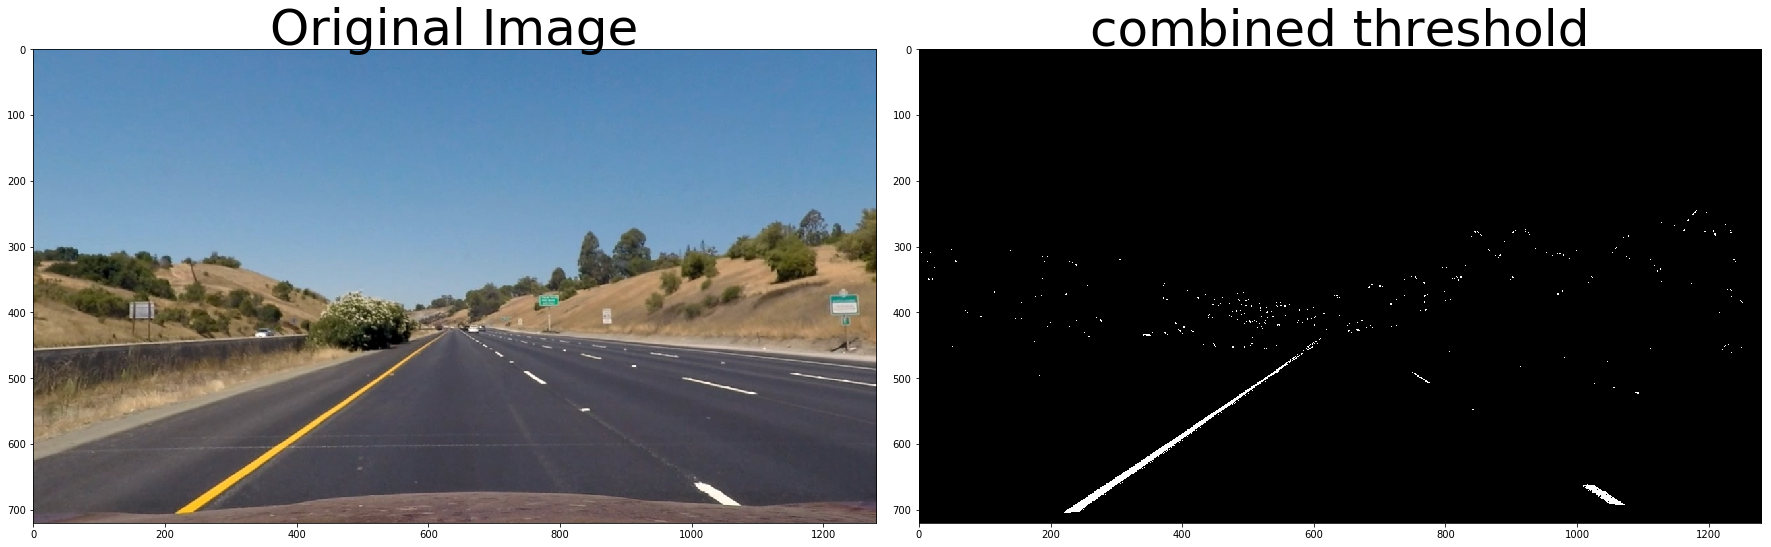

In [14]:
def Combine_all_thresholds(grad_binary_x, grad_binary_y, mag_binary, dir_binary, hls_binary, luv_binary):
    # Combine the previous thresholds
    CombinedThresh = np.zeros_like(dir_binary)
    CombinedThresh[((grad_binary_x == 1) & (grad_binary_y == 1)) & (( dir_binary== 1) & (mag_binary  == 1)) | (hls_binary == 1)|(luv_binary ==1)] = 1

    return CombinedThresh

#visualize the result
CombinedOutput = Combine_all_thresholds(grad_binary_x, grad_binary_y, mag_binary, dir_binary, hls_binary, luv_binary)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(CombinedOutput, cmap='gray')
ax2.set_title('combined threshold', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


## BIrd View Perspective Transform

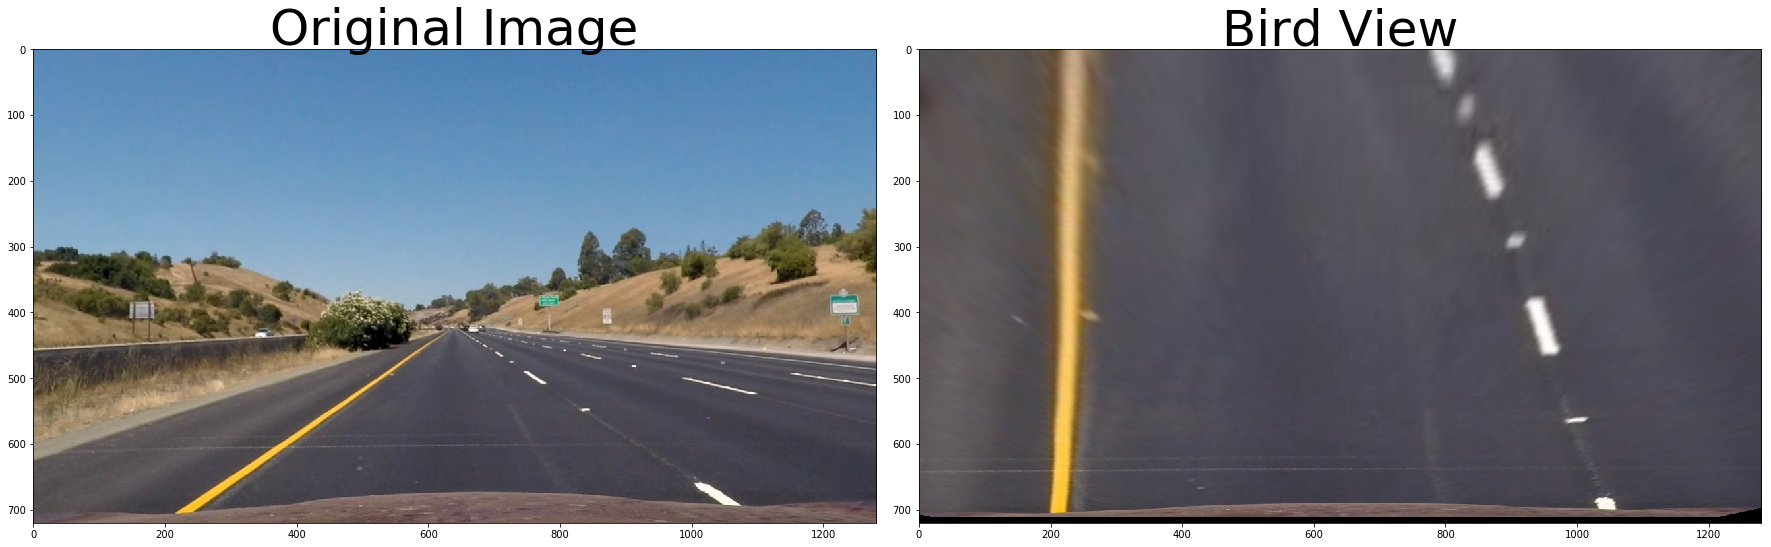

In [15]:
def Bird_View_Transform(img):
    img_size = (img.shape[1], img.shape[0])  
    #offset = 100
    #from botom left to top left to top right to top bottom
    src = np.float32([[290,695], [600,450], [730,450], [1100,695]])
    dst = np.float32([[260, 700], [260, 0], [1080, 0], [1080, 700]])
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # swapping the input parameters to get inverse perspective transfer
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Create warped image - uses linear interpolation
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

    return warped, M, Minv

# Visualize the result
warped_img, M , Minv  = Bird_View_Transform(img)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(warped_img, cmap='gray')
ax2.set_title('Bird View', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Get Histogram and detect lanes

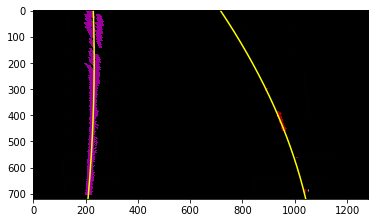

In [16]:
def detect_lanes(img):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(img[img.shape[0]//2:, :], axis=0)

   
    # prepare to visualizee the result
    out_img = np.dstack((img, img, img))*255
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    
    # HYPERPARAMETERS
    # margin of sliding window width
    margin = 100
    # Number of sliding windows
    nwindows = 9
    # minimum  pixel number to recenter window
    minpix = 50
    # according to window number and image shape to decide window height
    window_height = np.int(img.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])   
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window + 1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high), (0,255,0), 3) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high), (0,255,0), 3) 

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                          (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                           (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # 2nd polynomial fit to each side using `np.polyfit`
    right_fit = np.polyfit(righty, rightx, 2)
    left_fit = np.polyfit(lefty, leftx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0] - 1, img.shape[0])
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [100, 0, 100]
    out_img[righty, rightx] = [100, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
            
    return (left_fit, right_fit), (left_fitx, ploty), (right_fitx, ploty), out_img

# Visualize the output
combined_warped = Bird_View_Transform(CombinedOutput)[0]
FitLines, LeftPixels, RightPixels, out_img = detect_lanes(combined_warped)

# Plot the result
plt.imshow(out_img)

## Fine the lane boundary

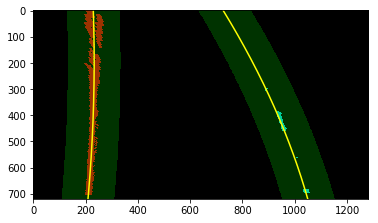

In [20]:
def Fine_lane_boundary(binary_warped, FitLines=None):
    #if no lanes are detected before.
    if FitLines is None:
        return detect_lanes(binary_warped)
    
    left_fit = FitLines[0]
    right_fit = FitLines[1]
    # HYPERPARAMETERS
    # Choose the width of the margin around the previous polynomial to search
    margin = 100
    nonzero = binary_warped.nonzero()
    nonzerox = np.array(nonzero[1])
    nonzeroy = np.array(nonzero[0])
    
     #Set the area of search based on activated x-values within the +/- margin of our polynomial function #
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    #extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # If any of the lines could not be found, 
    # perform a more exhaustive search
    #if (leftx.size == 0 or rightx.size == 0):
        #return detect_lines(binary_warped)
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])
    #Calc both polynomials using ploty, left_fit and right_fit
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [100, 0, 255]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 100, 100]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx - margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx + margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx - margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx + margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    out_img = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')  
    
     
    return (left_fit, right_fit), (left_fitx, ploty), (right_fitx, ploty), out_img
    

# Visualize the result
FitLines, LeftPixels, RightPixels, out_img = Fine_lane_boundary(combined_warped, FitLines)

# Plot the results
plt.imshow(out_img)

## Measure the real curve

In [21]:
def measure_real_curves (leftx, rightx):
    ploty = np.linspace(0, img.shape[0] - 1, img.shape[0])
    
    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y
    
    # Fit a second order polynomial to pixel positions in each fake lane line
    left_fit = np.polyfit(ploty, leftx, 2)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fit = np.polyfit(ploty, rightx, 2)
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    y_eval = np.max(ploty)
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    leftcurve = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    rightcurve = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return (leftcurve, rightcurve)

# Run to see the result
curves = measure_real_curves(leftx=LeftPixels[0], rightx=RightPixels[0])

# Print the results
print('Left line curvature:', curves[0], 'm')
print('Right line curvature:', curves[1], 'm')

Left line curvature: 1915.12320816 m
Right line curvature: 727.024608311 m


## Calculate the vehicle position

In [22]:
def Vehicle_Position(leftx, rightx):
    imgx_center = img.shape[1]//2
    #vehicle Position in the detected lane
    vehicle_position = (leftx[-1]+rightx[-1])/2;
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    OffSet = ( imgx_center-vehicle_position)*xm_per_pix
    
    return OffSet

# Run to see the result
offset= Vehicle_Position(leftx=LeftPixels[0], rightx=RightPixels[0])
print ('Offset is:', offset, 'm.')

Offset is: 0.056030431204 m.


## Drawing the lane

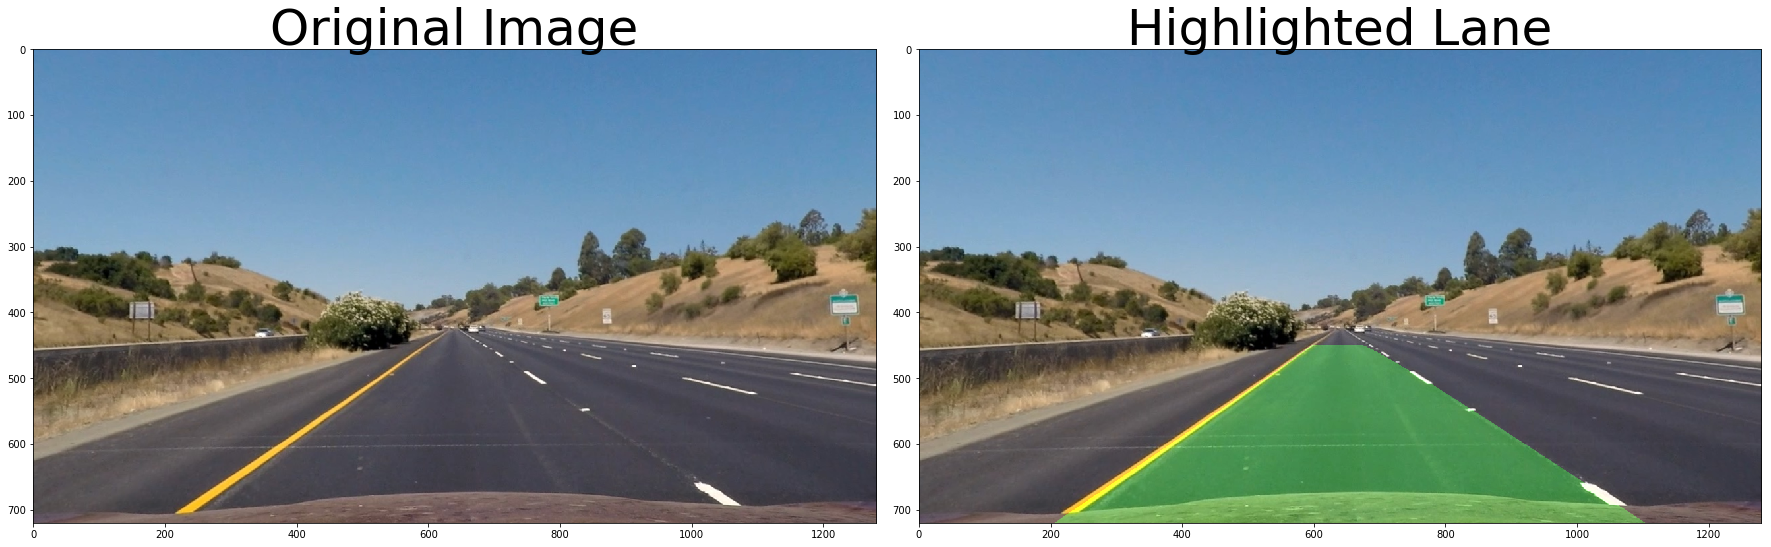

In [23]:
def drawing_lane(img, warped_img, LeftPixels, RightPixels, Minv):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    left_fitx = LeftPixels[0]
    right_fitx = RightPixels[0]
    ploty = LeftPixels[1]

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 


    return cv2.addWeighted(img, 1, newwarp, 0.3, 0)

# Visualize the result
img_lane = drawing_lane(img, combined_warped, LeftPixels, RightPixels, Minv)

# Plot the results
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(img_lane, cmap='gray')
ax2.set_title('Highlighted Lane', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Output curvature and vehicle offset


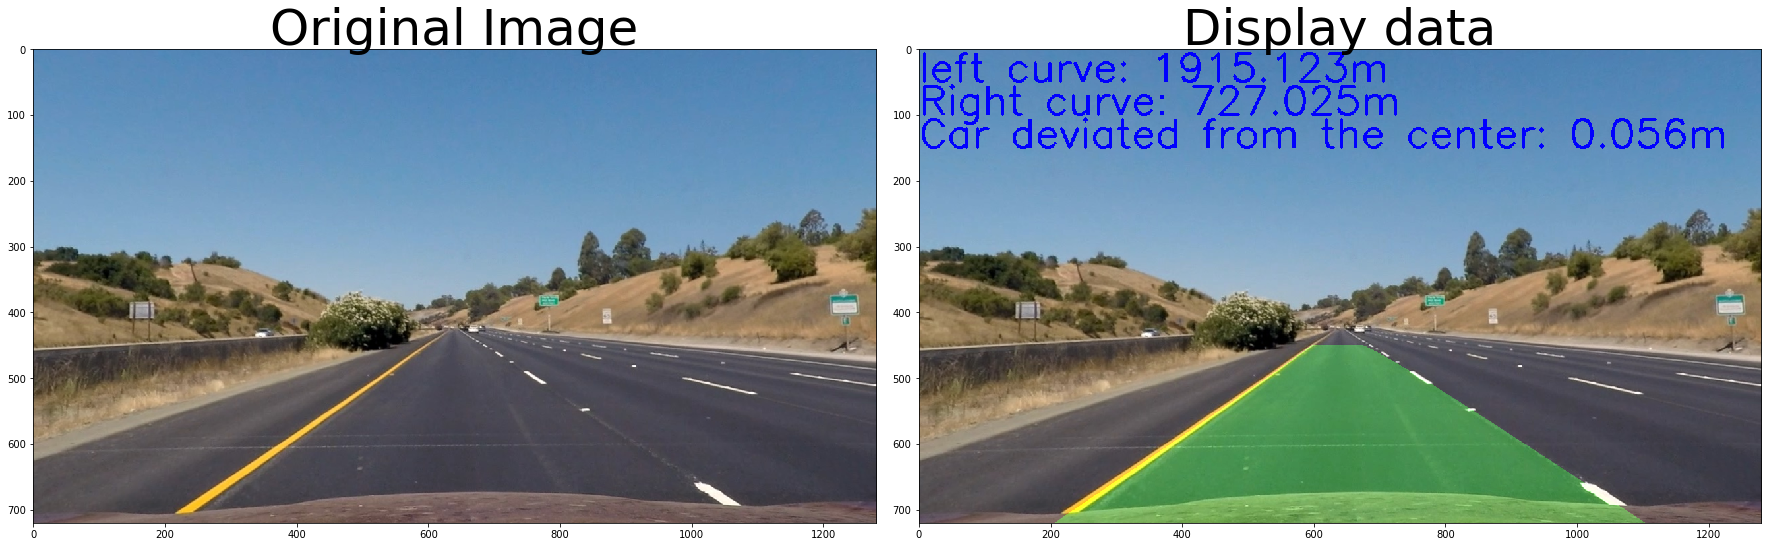

In [24]:
def Output_numbers(img, leftx, rightx):    
    # real curves
    curves= measure_real_curves (leftx, rightx)
    # vehicle postion
    vehicleOffset = Vehicle_Position(leftx=leftx, rightx=rightx)

    # Display 
    out_img = img.copy()
    cv2.putText(out_img, 'left curve: {:.3f}m'.format(curves[0]), 
                (0, 50), cv2.FONT_ITALIC, 2, (0,0,255), 4)
    cv2.putText(out_img, 'Right curve: {:.3f}m'.format(curves[1]), 
                (0, 100), cv2.FONT_ITALIC, 2, (0,0,255), 4)
    cv2.putText(out_img, 'Car deviated from the center: {:.3f}m'.format(vehicleOffset), 
                (0, 150), cv2.FONT_ITALIC, 2, (0,0,255), 4)
    
    return out_img

# Visualize the result
out_img = Output_numbers(img_lane, leftx=LeftPixels[0], rightx=RightPixels[0])

# Plot the results
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(out_img, cmap='gray')
ax2.set_title('Display data', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Create the pipeline for processing video

In [29]:
class Advanced_Finding_Lanes:
    def __init__(self, images):
        #Loading the images for camera calibration
        images = glob.glob(images)

        # camera calibration
        self.ret, self.mtx, self.dist, self.rvecs, self.tvecs = Camera_Calibration(images, 9, 6)
        self.FitLines = None

    def __call__(self, img):
        # Correct distortion using dist and mtx from camera caliration
        img = Distortion_Correction(img,mtx,dist)

        # Apply sobel operator for both X anf Y DIRECTION
        grad_binary_x = abs_sobel_thresh(img, orient='x',thresh_min=30, thresh_max=100)
        grad_binary_y = abs_sobel_thresh(img, orient='y',thresh_min=30, thresh_max=100)

        # find the magnitude of gradients
        mag_binary = mag_threshold(img, kernel=15, mag_thresh=(55, 100))

        # find the direction of gradient
        dir_binary = dir_threshold(img, kernel=15, thresh=(0.7, 1.3))

        # HLS threshold
        col_binary = hls_select(img, thresh=(170, 255))
        
        #LUV threshold
        luv_binary = luv_select(img, thresh=(225, 255))

        # Combined both color and gradiant thresholds
        CombinedOutput = Combine_all_thresholds(grad_binary_x, grad_binary_y, mag_binary, dir_binary, col_binary, luv_binary)

        #transform to bird view perspective
        combined_birdview_img, M, Minv = Bird_View_Transform(CombinedOutput)
        
        #decide lane boundaries
        self.FitLines, LeftPixels, RightPixels, out_img = Fine_lane_boundary(combined_birdview_img, self.FitLines)

        # show the detected lane area in the image and  paint it green
        img_lane = drawing_lane(img, combined_birdview_img, LeftPixels, RightPixels, Minv)
            
        # Output the curves and vehicle position offset data on the video
        Final_img = Output_numbers(img_lane, leftx=LeftPixels[0], rightx=RightPixels[0])
            
        return Final_img

Moviepy - Building video ./project_video_processed.mp4.
Moviepy - Writing video ./project_video_processed.mp4



t:  44%|███████████▌              | 558/1260 [03:19<04:11,  2.79it/s, now=None]

TypeError: expected non-empty vector for x

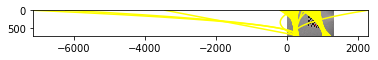

In [32]:
input_video = './project_video.mp4'
output_video = './project_video_processed.mp4'

#clip1 = VideoFileClip(input_video).subclip(0,5)
clip1 = VideoFileClip(input_video)

# Process video frames with our 'process_image' function
processed_video = Advanced_Finding_Lanes('./camera_cal/calibration*.jpg')

white_clip = clip1.fl_image(processed_video)

%time white_clip.write_videofile(output_video, audio=False)

In [33]:
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>

""".format(output_video))